In [54]:
import pandas as pd
import numpy as np
import tensorflow as tf
from y_engineering import *
from Indicators import *
import matplotlib.pyplot as plt

In [7]:
df = pd.read_csv("appl_clean_train.csv")

In [107]:
df['y_binary'] = df["pct"].apply(lambda x: 1 if x > 0 else 0)

In [155]:
ema(df, period=28, column='Adj Close', inplace=True)

0        0.789849
1        0.800179
2        0.822460
3        0.828960
4        0.824016
          ...    
4996    62.127544
4997    62.300201
4998    62.520821
4999    62.716276
5000    62.846138
Name: Adj Close, Length: 5001, dtype: float64

In [158]:
df["ema_pct"] = pct_log(df, y_col='ema_28', time_to_pred = 1, pct=True, log=False)

In [159]:
df

,Adj Close,Volume,pct_log,pct,y_binary,ema_21,ema_pct,ema_28
0,0.789849,459177600,NaN,NaN,0,0.789849,NaN,0.789849
1,0.809797,597643200,-0.105724,0.025255,1,0.800298,0.013079,0.800179
2,0.862517,1831132800,-0.298956,0.065103,1,0.823043,0.027844,0.822460
3,0.845894,495924800,0.131580,-0.019273,0,0.829596,0.007904,0.828960
4,0.807423,440876800,0.278119,-0.045480,0,0.824279,-0.005964,0.824016
...,...,...,...,...,...,...,...,...
4996,65.139717,84020400,0.004179,0.017534,1,63.019752,0.003604,62.127544
4997,64.631065,105207600,-0.001877,-0.007809,0,63.166235,0.002779,62.300201
4998,65.499199,65235600,0.003201,0.013432,1,63.378322,0.003541,62.520821
4999,65.354912,46617600,-0.000527,-0.002203,0,63.558012,0.003126,62.716276


In [9]:
def get_ordered_index(df, period_to_skip=31, val_split_ratio=0.2, period_from_end_skip=0):
    # get ordered dates split into train, val and test based on index
    all_dates = list(df.index)
    train = int(len(all_dates)*(1-val_split_ratio))

    train_dates = all_dates[period_to_skip:train]
    val_dates = all_dates[train:]
    return train_dates, val_dates

In [10]:
def get_x(df, y_index, x_col = 'pct', period=3):
    return df.loc[y_index-period:y_index-1, x_col]

In [14]:
def get_xy(df, period, x_col = 'pct', y_col='pct', val_split_ratio=0.2):
    train_i, val_i = get_ordered_index(df, period_to_skip=period+1, val_split_ratio=0.2)
    x_train = np.zeros((len(train_i),period))
    x_val = np.zeros((len(val_i),period))

    y_train = np.array(df.loc[train_i, y_col])
    y_val = np.array(df.loc[val_i, y_col])

    for i in range(len(train_i)):
        temp = np.array(get_x(df, train_i[i], x_col = x_col, period=period))
        x_train[i, :] = temp

    for i in range(len(val_i)):
        temp = np.array(get_x(df, val_i[i], x_col = x_col, period=period))
        x_val[i, :] = temp

    return x_train, y_train, x_val, y_val

In [20]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((3978, 21), (3978,), (1001, 21), (1001,))

In [23]:
x_train[0], y_train[0]

(array([ 0.02525546,  0.06510274, -0.01927266, -0.04547969,  0.05646978,
        -0.01837359, -0.00170181, -0.07613647,  0.02090962, -0.03373439,
        -0.01433921,  0.04554117,  0.04537129,  0.05613479,  0.00712397,
        -0.01958722,  0.00776872, -0.04184961,  0.06494148,  0.02752332,
        -0.0409659 ]),
 0.0065723704464715)

In [27]:
from tensorflow.keras import layers
from tensorflow import keras

In [137]:
period =14
x_train, y_train, x_val, y_val = get_xy(df, period, y_col="y_binary")

In [138]:
def basic_cnn_binary(period):
        
    inputs = tf.keras.Input(shape=(period,1,))
    
    # x = layers.Conv1D(16, kernel_size=5, strides=3, activation='relu')(inputs)
    x = layers.Conv1D(8, kernel_size=3, strides=1, activation='relu')(inputs)
    x = layers.Conv1D(1, kernel_size=1, strides=1, activation='relu')(x)
    
    # x = layers.LSTM(16, return_sequences=True, return_state=True)(x)
    x = layers.LSTM(16, return_sequences=False, return_state=False)(x)
    
    ema_input = tf.keras.Input(
    
    x = tf.keras.layers.Dense(32)(x)
    x = tf.keras.layers.Dense(8)(x)
    outputs = tf.keras.layers.Dense(1)(x)
    
    model = keras.Model(inputs, outputs) 
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
            loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
            metrics=[tf.keras.metrics.binary_accuracy])
    
    return model

In [160]:
def indicator_cnn_binary(period):
        
    inputs = tf.keras.Input(shape=(period,1,))
    
    # x = layers.Conv1D(16, kernel_size=5, strides=3, activation='relu')(inputs)
    x = layers.Conv1D(8, kernel_size=3, strides=1, activation='relu')(inputs)
    x = layers.Conv1D(1, kernel_size=1, strides=1, activation='relu')(x)
    
    # x = layers.LSTM(16, return_sequences=True, return_state=True)(x)
    x = layers.LSTM(16, return_sequences=False, return_state=False)(x)
    
    inputs_ind = keras.Input(shape=(7,1,))
    indicators = layers.Conv1D(8, kernel_size=3, strides=1, activation='relu')(inputs_ind)
    indicators = layers.Conv1D(1, kernel_size=1, strides=1, activation='relu')(indicators)
    indicators = keras.Model(inputs=inputs_ind, outputs=indicators)
    
    combined = layers.concatenate([x.output, indicators.output])
#     output = layers.Dropout(0.3)(combined)
    output = layers.Dense(32, activation="relu",
                          activity_regularizer=None)(combined)
#     output = layers.Dropout(0.3)(output)
    output = layers.Dense(16, activation="relu",
                          activity_regularizer=None)(output)
    # output = layers.Dropout(0.2)(output)
    output = layers.Dense(1, activation="linear")(output)
    model_combined = keras.models.Model(
        inputs=[x.input, indicators.input],
        outputs=output)    
    
    model_combined.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
            loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
            metrics=[tf.keras.metrics.binary_accuracy])
    
    return model

In [161]:
model = indicator_cnn_binary(period)
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 14, 1)]           0         
                                                                 
 conv1d_35 (Conv1D)          (None, 12, 8)             32        
                                                                 
 conv1d_36 (Conv1D)          (None, 12, 1)             9         
                                                                 
 lstm_18 (LSTM)              (None, 16)                1152      
                                                                 
 dense_27 (Dense)            (None, 32)                544       
                                                                 
 dense_28 (Dense)            (None, 8)                 264       
                                                                 
 dense_29 (Dense)            (None, 1)                 9   

In [139]:
model = basic_cnn_binary(per`iod)
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 14, 1)]           0         
                                                                 
 conv1d_33 (Conv1D)          (None, 12, 8)             32        
                                                                 
 conv1d_34 (Conv1D)          (None, 12, 1)             9         
                                                                 
 lstm_17 (LSTM)              (None, 16)                1152      
                                                                 
 dense_24 (Dense)            (None, 32)                544       
                                                                 
 dense_25 (Dense)            (None, 8)                 264       
                                                                 
 dense_26 (Dense)            (None, 1)                 9   

In [140]:
history = model.fit(x_train, y_train, batch_size=254, epochs=100, validation_split=0.2)
test_scores = model.evaluate(x_val, y_val, verbose=2)

Epoch 1/100
13/13 [==============================] - 1s 29ms/step - loss: 0.6927 - accuracy: 0.4815 - val_loss: 0.6939 - val_accuracy: 0.4969
Epoch 2/100
13/13 [==============================] - 0s 8ms/step - loss: 0.6925 - accuracy: 0.4815 - val_loss: 0.6937 - val_accuracy: 0.4969
Epoch 3/100
13/13 [==============================] - 0s 8ms/step - loss: 0.6926 - accuracy: 0.4815 - val_loss: 0.6935 - val_accuracy: 0.4969
Epoch 4/100
13/13 [==============================] - 0s 9ms/step - loss: 0.6925 - accuracy: 0.4815 - val_loss: 0.6937 - val_accuracy: 0.4969
Epoch 5/100
13/13 [==============================] - 0s 8ms/step - loss: 0.6925 - accuracy: 0.4815 - val_loss: 0.6936 - val_accuracy: 0.4969
Epoch 6/100
13/13 [==============================] - 0s 8ms/step - loss: 0.6925 - accuracy: 0.4815 - val_loss: 0.6935 - val_accuracy: 0.4969
Epoch 7/100
13/13 [==============================] - 0s 8ms/step - loss: 0.6927 - accuracy: 0.4815 - val_loss: 0.6935 - val_accuracy: 0.4969
Epoch 8/100


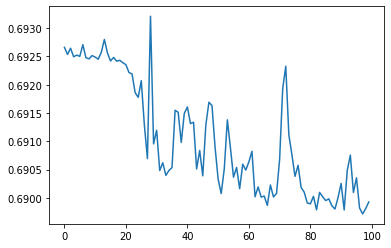

In [141]:
plt.plot(history.history['loss'])

In [142]:
x_pred = model.predict(x_val)

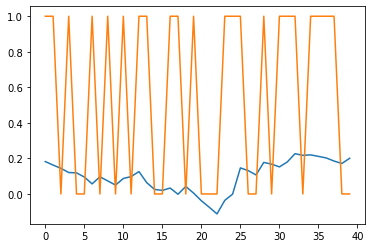

In [143]:
plt.plot(x_pred[20:60])
plt.plot(y_val[20:60])

(array([  8.,  10.,   8.,  27.,  32.,  40.,  64., 118., 228., 466.]),
 array([-0.14700252, -0.10284975, -0.05869698, -0.01454421,  0.02960856,
         0.07376133,  0.1179141 ,  0.16206686,  0.20621964,  0.2503724 ,
         0.29452518], dtype=float32),
 <BarContainer object of 10 artists>)

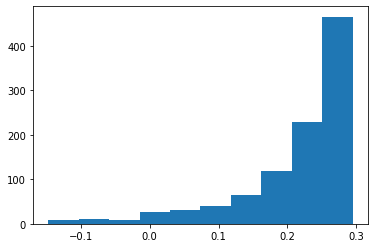

In [144]:
plt.hist(x_pred)

In [116]:
period =5 
x_train, y_train, x_val, y_val = get_xy(df, period)

In [93]:
def basic_cnn_lstm(period):
    
    inputs = tf.keras.Input(shape=(period,1,))
    
    # x = layers.Conv1D(16, kernel_size=5, strides=3, activation='relu')(inputs)
    x = layers.Conv1D(8, kernel_size=3, strides=1, activation='relu')(inputs)
    x = layers.Conv1D(1, kernel_size=1, strides=1, activation='relu')(x)
    
    # x = layers.LSTM(16, return_sequences=True, return_state=True)(x)
    x = layers.LSTM(16, return_sequences=False, return_state=False)(x)
    
    
    x = tf.keras.layers.Dense(32)(x)
    x = tf.keras.layers.Dense(8)(x)
    outputs = tf.keras.layers.Dense(1)(x)
    
    model = keras.Model(inputs, outputs) 
    
    model.compile(loss = 'mse', 
                    optimizer = "adam",               
                    metrics = ['mae'])
    
    return model

In [94]:
model = basic_cnn_lstm(period)
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 5, 1)]            0         
                                                                 
 conv1d_27 (Conv1D)          (None, 3, 8)              32        
                                                                 
 conv1d_28 (Conv1D)          (None, 3, 1)              9         
                                                                 
 lstm_14 (LSTM)              (None, 16)                1152      
                                                                 
 dense_15 (Dense)            (None, 32)                544       
                                                                 
 dense_16 (Dense)            (None, 8)                 264       
                                                                 
 dense_17 (Dense)            (None, 1)                 9   

In [95]:
history = model.fit(x_train, y_train, batch_size=254, epochs=20, validation_split=0.2)
test_scores = model.evaluate(x_val, y_val, verbose=2)

Epoch 1/20
13/13 [==============================] - 1s 25ms/step - loss: 8.9533e-04 - mae: 0.0209 - val_loss: 2.8276e-04 - val_mae: 0.0121
Epoch 2/20
13/13 [==============================] - 0s 5ms/step - loss: 8.6059e-04 - mae: 0.0202 - val_loss: 2.8326e-04 - val_mae: 0.0120
Epoch 3/20
13/13 [==============================] - 0s 4ms/step - loss: 8.5716e-04 - mae: 0.0201 - val_loss: 2.8502e-04 - val_mae: 0.0121
Epoch 4/20
13/13 [==============================] - 0s 4ms/step - loss: 8.5904e-04 - mae: 0.0202 - val_loss: 2.8394e-04 - val_mae: 0.0121
Epoch 5/20
13/13 [==============================] - 0s 5ms/step - loss: 8.5688e-04 - mae: 0.0201 - val_loss: 2.8472e-04 - val_mae: 0.0121
Epoch 6/20
13/13 [==============================] - 0s 4ms/step - loss: 8.5466e-04 - mae: 0.0201 - val_loss: 2.8598e-04 - val_mae: 0.0121
Epoch 7/20
13/13 [==============================] - 0s 4ms/step - loss: 8.6213e-04 - mae: 0.0203 - val_loss: 2.8518e-04 - val_mae: 0.0121
Epoch 8/20
13/13 [===============

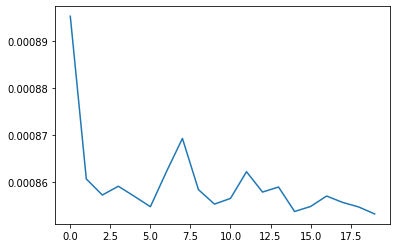

In [96]:
plt.plot(history.history['loss'])

In [103]:
history.history['mae'][-1]

0.020092910155653954

In [97]:
x_pred = model.predict(x_val)

In [98]:
x_pred

array([[0.00441085],
       [0.00422285],
       [0.00434896],
       ...,
       [0.00362943],
       [0.00359191],
       [0.00370103]], dtype=float32)

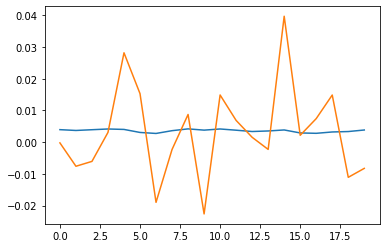

In [99]:
plt.plot(x_pred[40:60])
plt.plot(y_val[40:60])

(array([  5.,  14.,  52.,  82., 251., 360., 171.,  43.,  14.,   9.]),
 array([0.0019242 , 0.00228462, 0.00264504, 0.00300546, 0.00336588,
        0.0037263 , 0.00408672, 0.00444714, 0.00480755, 0.00516797,
        0.00552839], dtype=float32),
 <BarContainer object of 10 artists>)

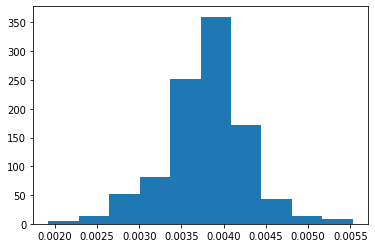

In [102]:
plt.hist(x_pred)